In [121]:
# adds scripts/ and src/ folder: so you can import scripts/functions across project steps
import sys 
sys.path.append("../../src")
sys.path.append("../../scripts")

from os import listdir
from os import path

import pandas as pd
from PIL import Image
import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from data_filepaths import image_folders, portraits_csv, images_with_boxes_folder, object_detection_results_csv_folder

### choose model setup to investigate 

In [122]:
MODEL = "resnet"# model FasterRCNN+InceptionResNet V2: higher accuracy,
#MODEL = "mobilenet" # model ssd+mobilenet V2: small and fast.

CASE_STUDY_TITLE = "portraits_before1800_maxpixels1024x1024"

DETECTION_SCORE_THRESHOLD = 0.3

object_detection_results_csv_folder = object_detection_results_csv_folder.replace("<CASESTUDY>", CASE_STUDY_TITLE).replace("<MODEL>", MODEL)
images_with_boxes_folder = images_with_boxes_folder.replace("<CASESTUDY>", CASE_STUDY_TITLE).replace("<MODEL>", MODEL)


### load detected objects list

In [93]:
results_per_image = [
    pd.read_csv(path.join(object_detection_results_csv_folder, csv_path))
    for csv_path in listdir(object_detection_results_csv_folder)
]

def fix_byte_dirt(str):
    if len(str)<4:
        return str
    if str[0:2]=="b'":
        str = str[2:len(str)]
    if str[-1]=="'":
        str = str[0:-1]
    return str

for dtf in results_per_image:
    dtf.detection_class_entities = dtf.detection_class_entities.apply(fix_byte_dirt)

In [94]:
results_per_image[0]

,Unnamed: 0,detection_scores,detection_class_entities,detection_class_labels,x0,y0,x1,y1,new_filename
0,0,0.909565,Human face,502,0.063721,0.482742,0.246708,0.713848,90385.jpg
1,1,0.891247,Animal,561,0.139218,0.157474,0.943617,1.000000,90385.jpg
2,2,0.520902,Sculpture,359,0.039222,0.101160,0.963449,0.936596,90385.jpg
3,3,0.262592,Man,308,0.018678,0.131586,0.984132,0.951767,90385.jpg
4,4,0.255108,Person,69,0.027351,0.114781,0.930034,0.916930,90385.jpg
...,...,...,...,...,...,...,...,...,...
95,95,0.002401,Human face,502,0.046207,0.452340,0.196391,0.721028,90385.jpg
96,96,0.002389,Human mouth,148,0.187267,0.620708,0.203768,0.674533,90385.jpg
97,97,0.002337,Marine mammal,525,0.107786,0.152856,0.992251,0.962081,90385.jpg
98,98,0.002281,Lion,419,0.144348,0.193656,0.920537,0.924084,90385.jpg


In [95]:
# ,detection_class_labels,detection_class_entities,detection_scores,x0,y0,x1,y1,new_filename
relevant_columns = ["detection_class_labels", "detection_class_entities", "detection_scores", "new_filename"]

def unique_detection_classes(result_dtf):
    return result_dtf[relevant_columns].groupby(
        ['detection_class_labels', "detection_class_entities", "new_filename"], as_index=False).agg(
        {'detection_scores':max}
    )

In [96]:
global_uresults = pd.concat([unique_detection_classes(res) for res in results_per_image])
global_uresults = global_uresults[global_uresults.detection_scores>DETECTION_SCORE_THRESHOLD]

In [97]:
global_uresults

,detection_class_labels,detection_class_entities,new_filename,detection_scores
29,359,Sculpture,90385.jpg,0.520902
42,502,Human face,90385.jpg,0.909565
48,561,Animal,90385.jpg,0.891247
1,21,Human beard,59920.jpg,0.363266
5,90,Necklace,59920.jpg,0.685837
...,...,...,...,...
4,69,Person,4975.jpg,0.497483
12,228,Woman,4975.jpg,0.652759
20,359,Sculpture,4975.jpg,0.321929
23,433,Clothing,4975.jpg,0.749542


### Global statistics

In [98]:
nb_portraits_per_object_class = global_uresults.groupby(
        ['detection_class_labels', "detection_class_entities"], as_index=False).agg(
        {'detection_scores':max, "new_filename": "nunique"}
    )
nb_portraits_per_object_class["nb_portraits"] = nb_portraits_per_object_class["new_filename"]
del nb_portraits_per_object_class["new_filename"]
nb_portraits_per_object_class.sort_values(by="nb_portraits", ascending=False, inplace=True)
nb_portraits_per_object_class[0:40]

,detection_class_labels,detection_class_entities,detection_scores,nb_portraits
99,502,Human face,0.993686,2200
88,433,Clothing,0.950583,2088
47,228,Woman,0.953407,1300
64,308,Man,0.978399,1198
11,69,Person,0.909900,752
10,58,Dress,0.948151,250
59,277,Fashion accessory,0.935841,240
89,434,Footwear,0.872777,217
32,161,Hat,0.903098,181
77,391,Tree,0.938078,123


In [99]:
nb_portraits_per_object_class[40:80]

,detection_class_labels,detection_class_entities,detection_scores,nb_portraits
94,462,Building,0.726742,8
113,590,Crown,0.925682,7
3,22,Bird,0.937221,7
38,193,Food,0.764062,6
72,357,Rose,0.808382,6
24,122,Cat,0.759552,6
16,91,Carnivore,0.705657,6
80,403,Violin,0.907868,5
91,447,Book,0.868223,5
5,30,Skull,0.991333,5


### Getting images with given objects combinations

In [100]:
results_per_image[0]

,Unnamed: 0,detection_scores,detection_class_entities,detection_class_labels,x0,y0,x1,y1,new_filename
0,0,0.909565,Human face,502,0.063721,0.482742,0.246708,0.713848,90385.jpg
1,1,0.891247,Animal,561,0.139218,0.157474,0.943617,1.000000,90385.jpg
2,2,0.520902,Sculpture,359,0.039222,0.101160,0.963449,0.936596,90385.jpg
3,3,0.262592,Man,308,0.018678,0.131586,0.984132,0.951767,90385.jpg
4,4,0.255108,Person,69,0.027351,0.114781,0.930034,0.916930,90385.jpg
...,...,...,...,...,...,...,...,...,...
95,95,0.002401,Human face,502,0.046207,0.452340,0.196391,0.721028,90385.jpg
96,96,0.002389,Human mouth,148,0.187267,0.620708,0.203768,0.674533,90385.jpg
97,97,0.002337,Marine mammal,525,0.107786,0.152856,0.992251,0.962081,90385.jpg
98,98,0.002281,Lion,419,0.144348,0.193656,0.920537,0.924084,90385.jpg


In [186]:
def get_images_with_objects_combination(results_per_image,
                                        detection_class_entities_list,
                                        detection_scores_threshold=DETECTION_SCORE_THRESHOLD):
        """Returns the 'new_filename' of the images containing all the specified given detection_class_entities
                
        Only consider entities with detection score above given threshold
        """
        img_objects = [
            (dtf.new_filename[0], set(dtf.detection_class_entities[dtf.detection_scores>detection_scores_threshold]))
            for dtf in results_per_image if dtf.shape[0]>0
        ]
        
        return [image_name for image_name, detected_objects in img_objects if all(c in detected_objects for c in detection_class_entities_list)]
        
        

In [187]:
results_per_image[0].new_filename[0]

'90385.jpg'

In [189]:
def show_images(images_paths, columns=3):
    
    # create figure
    fig = plt.figure(figsize=(15,15))

    # setting values to rows and column variables
    rows = int(np.ceil(len(images_paths)/float(columns)))
    columns = int(columns)
    
    for i, img_path in enumerate(images_paths):
        img = Image.open(img_path)
        
        fig.add_subplot(rows, columns, i+1)

        # showing image
        plt.imshow(img)
        plt.axis('off')
        plt.title(path.basename(img_path))

In [204]:
selected_images = get_images_with_objects_combination(results_per_image, ["Dog"])
#images_with_animals

In [205]:
full_paths = [path.join(images_with_boxes_folder, p) for p in selected_images]
full_paths[0:3]

['../../data/object_detection_results/portraits_before1800_maxpixels1024x1024_resnet/images_with_boxes/82609.jpg',
 '../../data/object_detection_results/portraits_before1800_maxpixels1024x1024_resnet/images_with_boxes/95191.jpg',
 '../../data/object_detection_results/portraits_before1800_maxpixels1024x1024_resnet/images_with_boxes/61458.jpg']

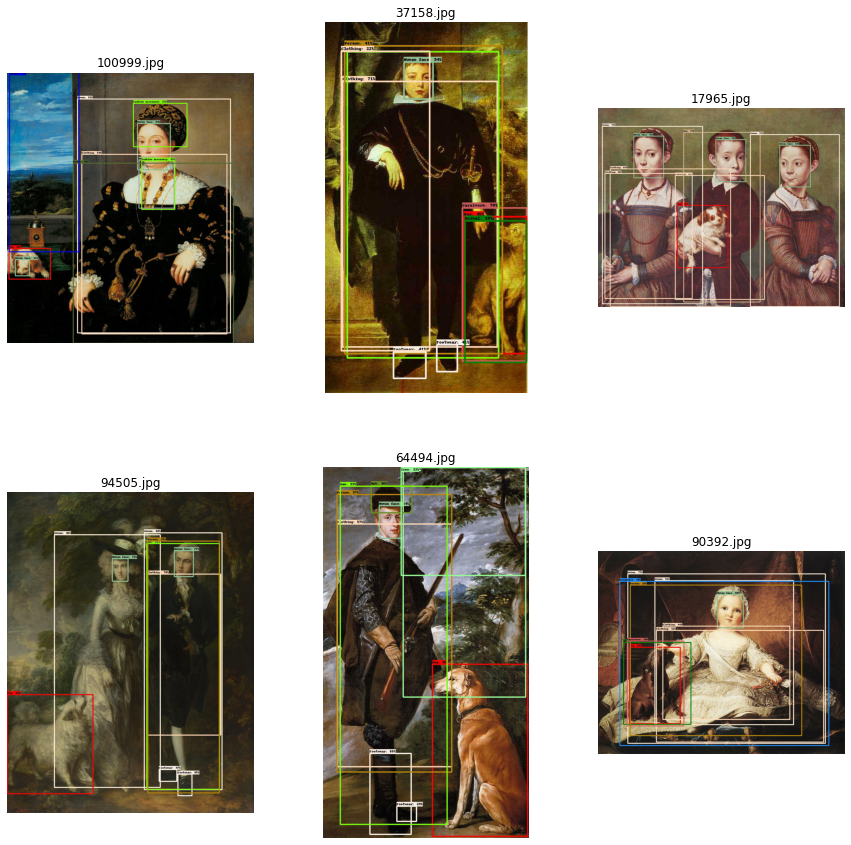

In [207]:

show_images(full_paths[12:18])

33.0